In [1]:
from qiskit import *
import numpy as np
from qiskit.quantum_info import DensityMatrix
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Statevector
from sympy import Matrix
from qiskit.aqua.utils import get_subsystem_density_matrix

#### Density matrix of an IBM quantum computer generated GHZ state:  
we will use the distribution of states given by running the 4-qubit GHZ circuit to create a statevector which we use to  
create density matrices and run partial traces to describe subsystem reduced density matrices.

In [11]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
import qiskit.quantum_info as qi
import time

from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

In [6]:
qr = QuantumRegister(4)
GHZ_circ = QuantumCircuit(qr)
GHZ_circ.h(qr[0])
GHZ_circ.cx(qr[0], qr[1])
GHZ_circ.cx(qr[1], qr[2])
GHZ_circ.cx(qr[2], qr[3])

print(GHZ_circ)

target_state = qi.Statevector.from_instruction(GHZ_circ)
print(target_state)

       ┌───┐               
q48_0: ┤ H ├──■────────────
       └───┘┌─┴─┐          
q48_1: ─────┤ X ├──■───────
            └───┘┌─┴─┐     
q48_2: ──────────┤ X ├──■──
                 └───┘┌─┴─┐
q48_3: ───────────────┤ X ├
                      └───┘
Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2, 2, 2))


In [43]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

E:\ANACONDA\envs\Qiskit\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-12-07 04:25:03,464: Credentials are already in use. The existing account in the session will be replaced.


In [14]:
from qiskit.providers.aer import noise
from qiskit.compiler import assemble

noise_model = noise.NoiseModel()
for qubit in range(4):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.3,0.7]])
    noise_model.add_readout_error(read_err,[qubit])

In [15]:
qcomp = provider.get_backend('ibmq_qasm_simulator') 
t = time.time()

meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2,3])
job_cal = qiskit.execute(meas_calibs, backend=qcomp, shots=4000, noise_model=noise_model)

# Generate the state tomography circuits.
qst_GHZ = state_tomography_circuits(GHZ_circ, [qr[0], qr[1],qr[2],qr[3]])

# Execute
job = qiskit.execute(qst_GHZ, backend= qcomp, shots=4000,noise_model=noise_model)

print('Time taken:', time.time() - t)


Time taken: 4.456462621688843


In [16]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [17]:
# Fit result
meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)
tomo_fitter_GHZ = StateTomographyFitter(job.result(), qst_GHZ)

In [18]:
# Perform the tomography fit
# which outputs a density matrix
rho_fit_GHZ = tomo_fitter_GHZ.fit(method='lstsq')
F_GHZ = qi.state_fidelity(rho_fit_GHZ, target_state)
print('State Fidelity: F = {:.5f}'.format(F_GHZ))

State Fidelity: F = 0.16564


In [19]:
correct_tomo_results = meas_fitter.filter.apply(job.result(), method='least_squares')
tomo_fitter_GHZ_mit = StateTomographyFitter(correct_tomo_results, qst_GHZ)
rho_fit_GHZ_mit = tomo_fitter_GHZ_mit.fit(method='lstsq')
F_GHZ_mit = qi.state_fidelity(rho_fit_GHZ_mit, target_state)
print('State fidelity (w/ correction): F = {:.5f}'.format(F_GHZ_mit))

State fidelity (w/ correction): F = 0.72549


In [20]:
Matrix(rho_fit_GHZ);

In [21]:
Matrix(rho_fit_GHZ_mit);

In [42]:
Corrected_Tomography_state_2 = (np.round(rho_fit_GHZ_mit, 4))

Matrix(Corrected_Tomography_state_2);

In [34]:
from qiskit.quantum_info import DensityMatrix
My_corrected_GHZ_density_matrix = DensityMatrix(rho_fit_GHZ_mit)
My_corrected_GHZ_density_matrix.purity()

(0.6247226250717085+1.1669846660010034e-19j)

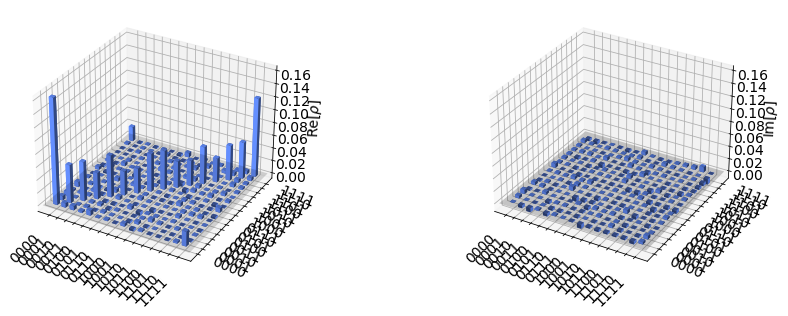

In [29]:
from qiskit.visualization import plot_state_city
plot_state_city(rho_fit_GHZ)

In [35]:
My_noisy_GHZ_density_matrix = DensityMatrix(rho_fit_GHZ)
My_noisy_GHZ_density_matrix.purity()

(0.08383273278756478-1.012451200326913e-22j)

In [41]:
Tomography_state = (np.round(rho_fit_GHZ, 4))

Matrix(Tomography_state);

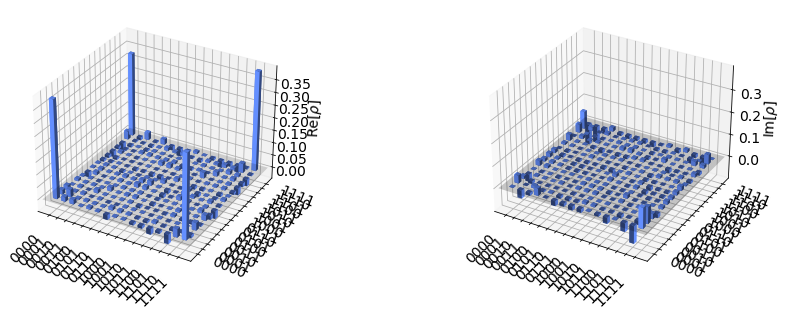

In [31]:
plot_state_city(rho_fit_GHZ_mit)

In [45]:
from IPython.core.display import display, HTML
## this line enlarges the width of all cells
display(HTML("<style>.container { width:70% !important; }</style>"))